In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.greedy=True

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
import sys 
import sklearn.metrics as metrics

sns.set_style('whitegrid')

In [7]:
df = pd.read_csv('./processed_data/merged_dataset_all_vwc_sensors.csv', sep=';', index_col=0)

df.rename(columns={'b13': 'b8a'}, inplace=True)
v3 = 'VWC_Avg.3.'
v6 = 'VWC_Avg.6.'
v9 = 'VWC_Avg.9.'

df = df.drop(columns=['EC_Avg.3.','EC_Avg.6.','EC_Avg.9.','Temp5TE_C_Avg.3.','Temp5TE_C_Avg.6.'
                      ,'Temp5TE_C_Avg.9.','AirTemp_C_Avg','RelHumid'])

df['VWC_Avg'] = df[[v3, v6, v9]].mean(axis=1) #compute average

stations = np.array(df['Station'].values)
ground = np.array([])
for station in stations:
    if station.startswith('M'):
        ground = np.append(ground, 'Mergel')
    elif station.startswith('Sa'):
        ground = np.append(ground, 'Sandstein')
    else:
        ground = np.append(ground, 'Schiefer')
df['ground'] = ground

df.head()

,Date,Station,Sensor1,Sensor2,Sensor3,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b8a,VWC_Avg,ground
0,20161124,M_C,0.353000,0.247000,0.294000,1442.000000,1086.428571,872.285714,630.714286,959.571429,1848.571429,2161.142857,1986.285714,623.000000,38.000000,1436.857143,749.285714,2433.428571,0.298000,Mergel
1,20161124,M_D,NaN,0.426000,0.256000,1485.714286,1125.571429,960.857143,787.285714,1167.714286,2049.571429,2473.428571,2489.714286,670.285714,42.000000,2102.428571,1177.000000,2923.000000,0.341000,Mergel
2,20161124,M_E,NaN,0.283000,0.347889,1772.000000,1431.142857,1255.285714,1055.571429,1462.857143,2610.714286,3087.571429,2981.000000,847.428571,218.142857,2287.714286,1276.285714,3435.428571,0.315444,Mergel
3,20161124,M_F,0.352944,NaN,NaN,2025.000000,1569.142857,1239.142857,1101.285714,1345.857143,1849.714286,2046.857143,1900.714286,1046.000000,456.000000,1517.571429,943.000000,2234.285714,0.352944,Mergel
4,20161124,M_G,0.293000,0.266444,0.347000,1527.000000,1245.285714,993.428571,757.714286,1051.857143,1830.571429,2156.285714,2098.142857,529.000000,130.000000,1513.142857,785.142857,2369.714286,0.302148,Mergel


In [52]:
#introduce class columns for every sensor and total
df['cl3'] = pd.Series(np.zeros(len(df.index)), index=df.index)
df['cl6'] = pd.Series(np.zeros(len(df.index)), index=df.index)
df['cl9'] = pd.Series(np.zeros(len(df.index)), index=df.index)
df['class'] = pd.Series(np.zeros(len(df.index)), index=df.index)

#digitize the VWC entries and write them to the new columns
bins = np.array([0.0, 0.2, 0.3, 1.0]) # classes 1,2,3,4
inds = np.digitize(df[[v3, v6, v9]], bins, right=True)
df[['cl3', 'cl6', 'cl9']] = inds

#procedure to determin the total class value
for index, row in df.iterrows():
    values = np.array([row['cl3'], row['cl6'], row['cl9']])
    nans = np.count_nonzero(values==len(bins))
    if nans==3: # if no sensor has an entry
        df['class'][index] = np.nan
    elif nans>0: # if 1 or 2 sensors have NaN the average is digitized
        ind = np.digitize(row['VWC_Avg'], bins, right=True)
        df['class'][index] = ind
    else: #if all sensors are working the majority wins
        unique, counts = np.unique(values, return_counts=True)
        if np.max(counts)>1:
            max_ind = np.argmax(counts)
            df['class'][index] = unique[max_ind]
        else:#if all sensors are in the same class the average is digitized
            ind = np.digitize(row['VWC_Avg'], bins, right=True)
            df['class'][index] = ind
             
df[[v3, v6, v9, 'VWC_Avg', 'cl3', 'cl6', 'cl9', 'class']].head()  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

,VWC_Avg.3.,VWC_Avg.6.,VWC_Avg.9.,VWC_Avg,cl3,cl6,cl9,class
0,0.353000,0.247000,0.294000,0.298000,3,2,2,2.0
1,NaN,0.426000,0.256000,0.341000,4,3,2,3.0
2,NaN,0.283000,0.347889,0.315444,4,2,3,3.0
3,0.352944,NaN,NaN,0.352944,3,4,4,3.0
4,0.293000,0.266444,0.347000,0.302148,2,2,3,2.0


In [53]:
df.to_csv('dataset_3bins_small_middle.csv')
print(df.head())

       Date Station  VWC_Avg.3.  VWC_Avg.6.  VWC_Avg.9.           b1  \
0  20161124     M_C    0.353000    0.247000    0.294000  1442.000000   
1  20161124     M_D         NaN    0.426000    0.256000  1485.714286   
2  20161124     M_E         NaN    0.283000    0.347889  1772.000000   
3  20161124     M_F    0.352944         NaN         NaN  2025.000000   
4  20161124     M_G    0.293000    0.266444    0.347000  1527.000000   

            b2           b3           b4           b5  ...          b10  \
0  1086.428571   872.285714   630.714286   959.571429  ...    38.000000   
1  1125.571429   960.857143   787.285714  1167.714286  ...    42.000000   
2  1431.142857  1255.285714  1055.571429  1462.857143  ...   218.142857   
3  1569.142857  1239.142857  1101.285714  1345.857143  ...   456.000000   
4  1245.285714   993.428571   757.714286  1051.857143  ...   130.000000   

           b11          b12          b8a   VWC_Avg  ground  cl3  cl6  cl9  \
0  1436.857143   749.285714  2433.42857

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, cohen_kappa_score
import sklearn.metrics as skm
from sklearn.preprocessing import LabelBinarizer, normalize

bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b8a']
df.dropna(subset=['class'], inplace=True)

is_testset = ((df['Station']=='M_F') | (df['Station']=='M_G') | (df['Station']=='S_Q') | (df['Station']=='Sa_K'))

df_test = df[is_testset].copy()
df_train = df[is_testset==False].copy()

df_test = df_test.sample(frac=1, random_state=42)
df_train = df_train.sample(frac=1, random_state=42)

X_train = df_train[bands]
Y_train = df_train['class']

X_test = df_test[bands]
Y_test = df_test['class']

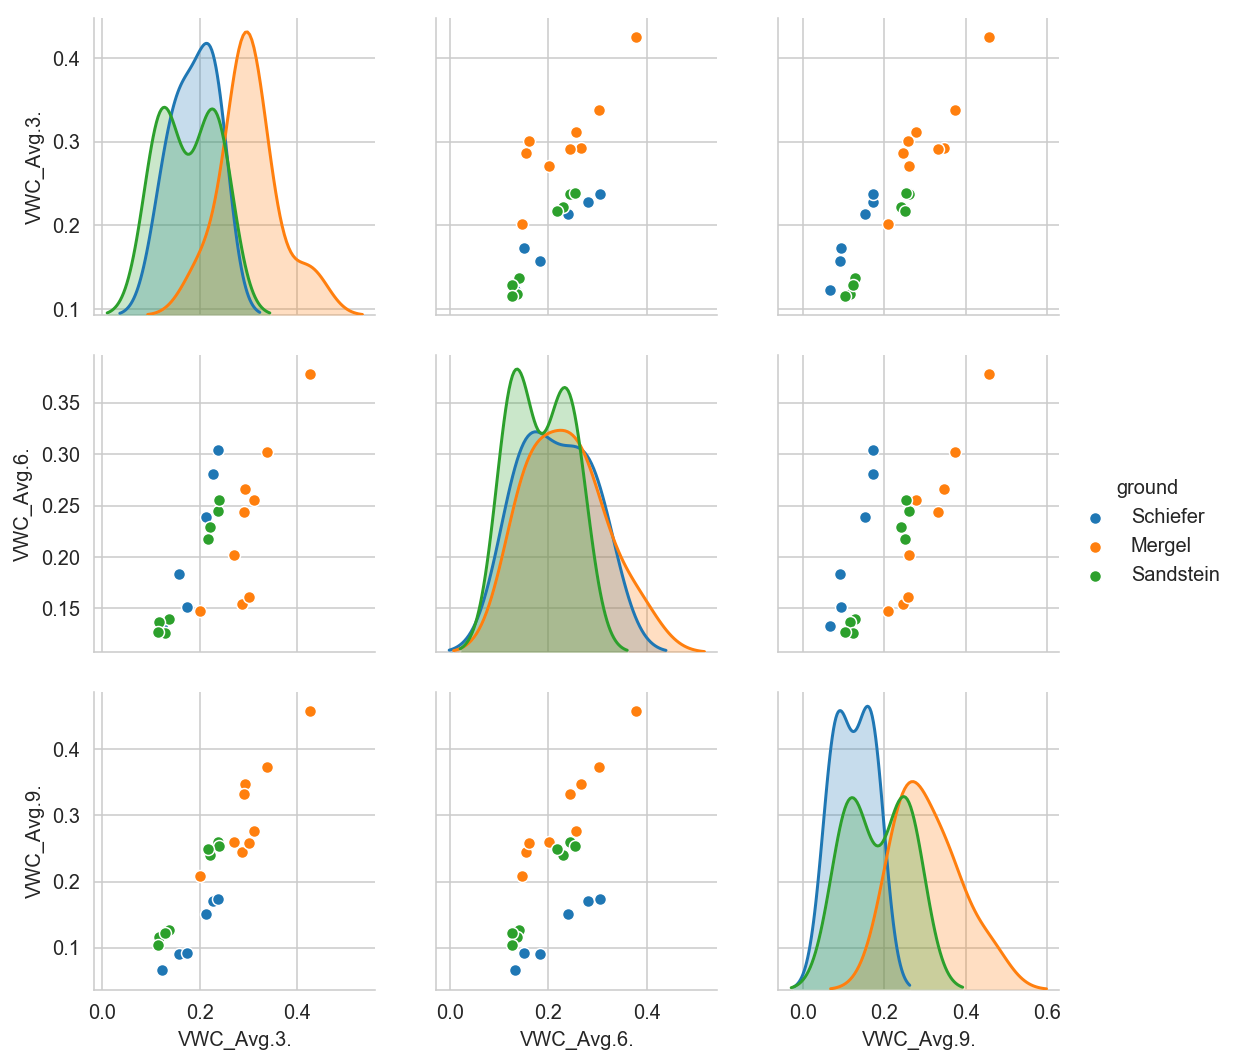

In [55]:
sns.pairplot(df_test[[v3, v6, v9, 'ground']].dropna(), hue='ground')
plt.show()

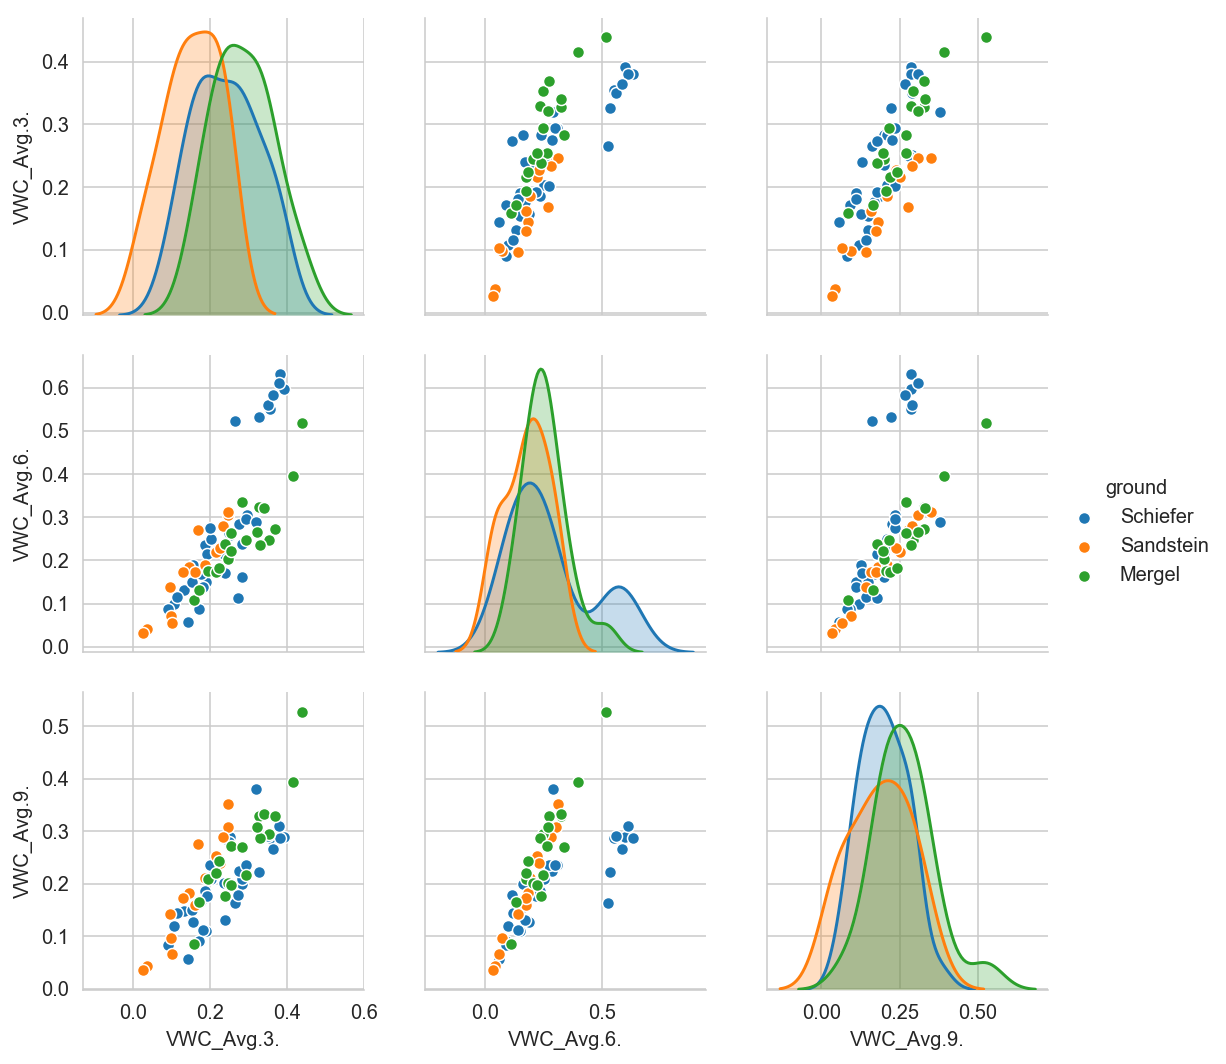

In [56]:
sns.pairplot(df_train[[v3, v6, v9, 'ground']].dropna(), hue='ground')
plt.show()

### Random forrest

In [57]:

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, Y_train)
pred_test = clf.predict(X_test)
pred_train = clf.predict(X_train)

print('accuracy: ', accuracy_score(Y_test, pred_test))
print('kappa: ', skm.cohen_kappa_score(Y_test.values, pred_test))

accuracy:  0.5862068965517241
kappa:  0.34090909090909094


### Extra trees

In [58]:

clf = ExtraTreesClassifier(n_estimators=300, random_state=0, n_jobs=-1)
clf.fit(X_train, Y_train)
pred_test = clf.predict(X_test)
pred_train = clf.predict(X_train)

print('accuracy: ', accuracy_score(Y_test, pred_test))
print('kappa: ', skm.cohen_kappa_score(Y_test.values, pred_test))

accuracy:  0.5862068965517241
kappa:  0.34463276836158185


### SVM

In [59]:
params_svm = {'C':np.logspace(3,5, 10), 'gamma':np.logspace(-10,-7,10)}
svm = SVC()
clf = GridSearchCV(svm, params_svm, n_jobs=-1) 
clf.fit(X_train, Y_train) 
print(clf.best_params_)

clf = clf.best_estimator_

clf.fit(X_train, Y_train)
print('#support vectors: ',len(clf.support_vectors_ ))
pred_test = clf.predict(X_test)
pred_train = clf.predict(X_train)

print('accuracy: ', accuracy_score(Y_test, pred_test))
print('kappa: ', skm.cohen_kappa_score(Y_test.values, pred_test))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 21544.346900318822, 'gamma': 4.641588833612773e-08}
#support vectors:  61
accuracy:  0.5172413793103449
kappa:  0.2724014336917562


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### MLP (keras)

In [60]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras_metrics
import sklearn.metrics as skm


df_test = df[is_testset].copy()
df_test = df_test.sample(frac=1, random_state=42)

x_test = df_test[bands]
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(df_test["class"])
y_test = pd.DataFrame(lb_results, columns=lb_style.classes_)

df_train = df[is_testset==False].copy()
df_train = df_train.sample(frac=1, random_state=42)

x_train = df_train[bands]
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(df_train["class"])
y_train = pd.DataFrame(lb_results, columns=lb_style.classes_)


random_state = 42
np.random.seed(random_state)
tf.set_random_seed(42)

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=13))
model.add(Dense(20, activation='relu'))
model.add(Dense(3, activation='softmax'))

sgd = SGD(lr=1.0, decay=1e-5, momentum=0.8, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

fit_result = model.fit(x_train, y_train,
          epochs=20,
          batch_size=128, verbose=False)



pred_test = model.predict(x_test)
pred_train = model.predict(x_train)

print('training')
print('accuracy: ', accuracy_score(np.argmax(y_train.values, axis=1), np.argmax(pred_train, axis=1)))
print('kappa: ', skm.cohen_kappa_score(np.argmax(y_train.values, axis=1), np.argmax(pred_train, axis=1)))
print('----------------------------------------------')
print('test')
print('accuracy: ', accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(pred_test, axis=1)))
print('kappa: ', skm.cohen_kappa_score(np.argmax(y_test.values, axis=1), np.argmax(pred_test, axis=1)))

        

training
accuracy:  0.358695652173913
kappa:  0.0
----------------------------------------------
test
accuracy:  0.5517241379310345
kappa:  0.0


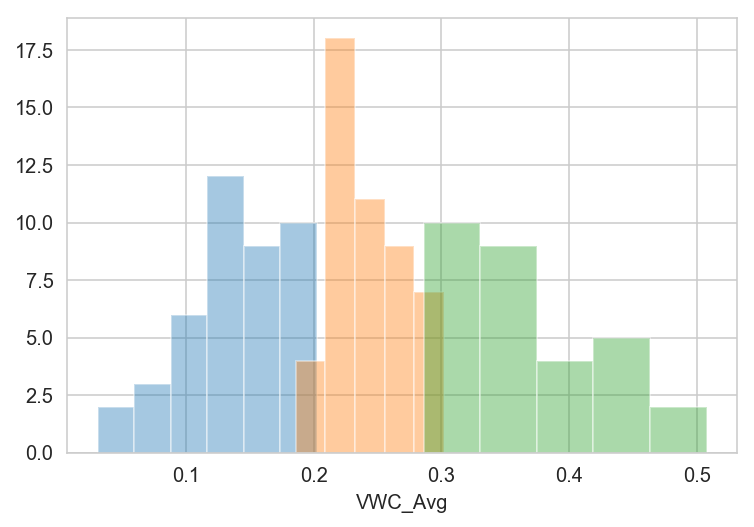

In [25]:
for i in range(1,4):
    bla = df[df['class']==i]
    sns.distplot(bla['VWC_Avg'], kde=False)
plt.savefig('dist_3_classes_middle_small.pdf')
plt.show()